# Assignment 1: Color Spaces, Morphological Operators

## Exercise 1.1

For an image of your choice, implement the simple binarization method as shown in the lecture. We've put some example images in in /images.

Rough sketch:

1. define the „positive“ subspace P in the RGB cube
2. iterate over all pixels in I and check if in P or ~P
3. write result to new image
4. play around with size and shape of P and display binary image (**RESULT**)



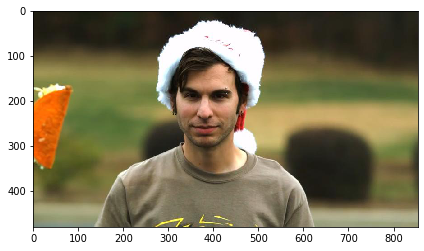

In [1]:
%matplotlib inline 
from skimage import io, data, color
import numpy as np

image = io.imread('images/taco/001.jpg')
io.imshow(image)

### Zoom in the taco to figure out RGB cube

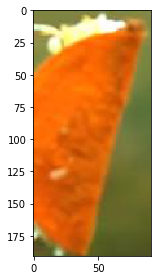

In [2]:
taco = image[160:351,:91]
io.imshow(taco)

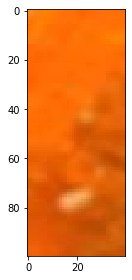

In [3]:
taco_part = taco[50:150,:40]
io.imshow(taco_part)

### Look at min/max taco color values

In [4]:
labels = ['r', 'g', 'b']
for i in range(3):
    print(f'min {labels[i]}: {np.min(taco_part[:,:,i])}')
    print(f'max {labels[i]}: {np.max(taco_part[:,:,i])}\n')

min r: 182
max r: 255

min g: 69
max g: 178

min b: 0
max b: 112



### Plot color histograms of R, G and B channels

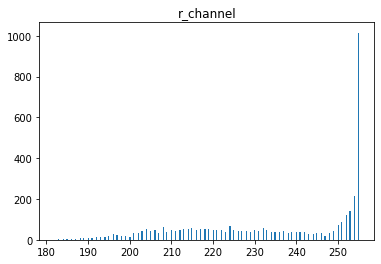

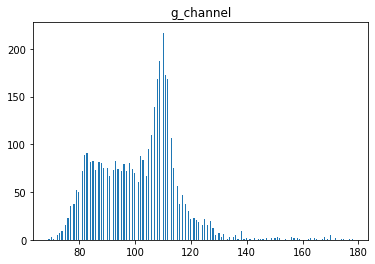

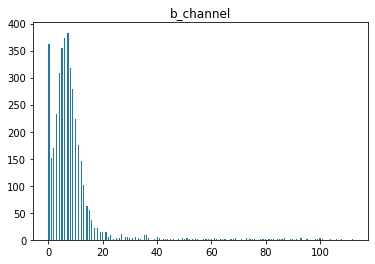

In [5]:
import matplotlib.pyplot as plt

labels = ['r_channel', 'g_channel', 'b_channel']

for i in range(3):
    hist = plt.hist(taco_part[:,:,i].ravel(), 256)
    plt.title(labels[i])
    plt.show()

### Binarize image

Based on the above data, we figured a RGB cube with lowest r,g and b values of 175, 70 and 0 respectively and a size of 80 will be optimal. For example, in the R-channel, we will match values between 175 and 255.

In [6]:
def binarize(img, cube=[175, 70, 0], size=80):
    res = np.zeros((img.shape[0], img.shape[1]))
    
    for y, row in enumerate(img):
        for x, rgb in enumerate(row):
            
            match = True
            for i, value in enumerate(rgb):
                if value < cube[i] or value > cube[i] + size:
                    match = False
                    break
                    
            if match:
                res[y,x] = 1
                    
    return res

/home/hristov/miniconda3/envs/cv/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


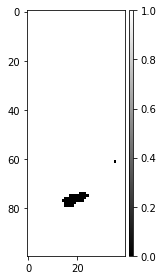

In [7]:
binary_taco = binarize(taco_part)
io.imshow(binary_taco, cmap=plt.cm.gray)

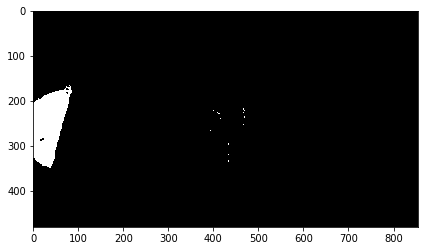

In [8]:
image_binary = binarize(image)
io.imshow(image_binary, cmap=plt.cm.gray)

## Exercise 1.2

* starting from the binary color detection image
* erase noise with an erosion operation
* dilate once to get original size of object
* find connected components with the two-pass algorithm
* extract bounding box on the fly
* draw bounding box on original image (**RESULT**)

### Padding of image

We are  going to apply erosion and dilation as convolution operations. Hence the size of the image will be decreased if we don't use any padding. To implement the operations as shown in the lectures, we decided to use zero-padding on the edge of the image so that its size is preserved.

In [9]:
def pad(img, padding):
    return np.pad(img, padding, 'constant')

def unpad(img, padding=1):
    return img[padding:-padding,padding:-padding]

### Erosion/Dialtion

As discussed, we are going to apply a convolution operation over the image. For each image location (x,y), if the result of the convolution is not zero, then a dilation operation will output 1 at this pixel location. Furthher, if the result of the convolution matches the amount of 1s in the kernel, then the result of an erotion operation will be 1. In other scenarios, the resulting image will have 0 at this pixel location.

In [10]:
cross_3x3 = np.array([[0,1,0], [1,1,1], [0,1,0]])
cross_5x5 = np.array([[0,0,1,0,0], [0,1,1,1,0], [1,1,1,1,1], [0,1,1,1,0], [0,0,1,0,0]])
cross_9x9 = np.array([
    [0,0,0,0,1,0,0,0,0],
    [0,0,0,1,1,1,0,0,0],
    [0,0,1,1,1,1,1,0,0],
    [0,1,1,1,1,1,1,1,0],
    [1,1,1,1,1,1,1,1,1],
    [0,1,1,1,1,1,1,1,0],
    [0,0,1,1,1,1,1,0,0],
    [0,0,0,1,1,1,0,0,0],
    [0,0,0,0,1,0,0,0,0],
])


def morphological_parse(img, kernel, method='erosion'):
    # we assume square matrices with an odd shape
    assert kernel.shape[0] % 2 == 1 and kernel.shape[0] == kernel.shape[1]
    
    # pad image to perform erosion/dilation
    padding = kernel.shape[0] // 2
    img = pad(img, padding)
    res = np.zeros(img.shape)
    kernel_sum = np.sum(kernel)
    
    # go through the region of the image where the kernel fits
    for y in range(padding, img.shape[0] - padding, 1):
        for x in range(padding, img.shape[1] - padding, 1):
            # extract current image part
            image_part = img[y - padding: y + padding + 1, x - padding: x + padding + 1]
            
            # most of the image is gonna be black
            # skip convoluting over such parts for better performance
            if not 1 in image_part:
                continue
                
            
            # apply convolution operation with kernel
            matched_squares = np.sum(image_part * kernel)
            
            # if the output is not zero, at least one part of the kernel matched
            # a non-zero part of the image
            if method == 'dilation' and matched_squares > 0:
                res[y, x] = 1
            # if the output is the #pixels in kernel, every 1 in the kernel was over 1 in image
            elif method == 'erosion' and matched_squares == kernel_sum:
                res[y, x] = 1
           
    # unpad image to return result over original one    
    return unpad(res, padding)

def erode(img, kernel=cross_9x9):
    return morphological_parse(img, kernel, method='erosion')

def dilate(img, kernel=cross_9x9):
    return morphological_parse(img, kernel, method='dilation')

CPU times: user 2.3 s, sys: 9.9 ms, total: 2.31 s
Wall time: 2 s


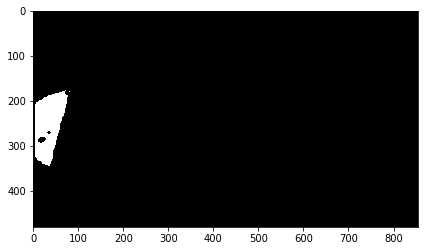

In [11]:
%%time
image_eroded = erode(image_binary)
io.imshow(image_eroded)

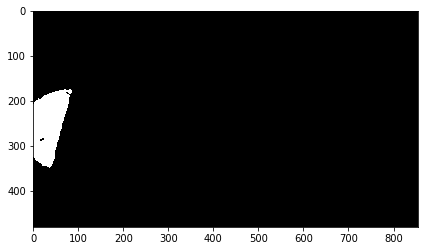

In [12]:
image_no_noise = dilate(image_eroded)
io.imshow(image_no_noise)

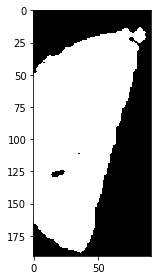

In [13]:
io.imshow(image_no_noise[160:351,:91])

### Connected components

We are going to implement the 2-pass algorithm. We are going to return a matrix with each cell stating to which connected component the corresponding image pixel belongs. Further, as we are interested in bounding boxes, we are also going to return an array of image locations for each connected component.

Note that we are using the 4-neighbor variation of the algorithm, thereby we only consider the west, north, east and south pixels as neighbors (we ignore e.g. nord-west pixels)

In [14]:
def get_connected_components(img):
    # work again on padded image
    img = pad(img, 1)
    
    res = np.zeros(img.shape)
    current_component = 1
    
    equiv_list = {0:0}
    blobs = {}
    
    # traverse image row-wise
    for y in range(1, img.shape[0] - 1, 1):
        for x in range(1, img.shape[1] - 1, 1):
            value = img[y,x]
            
            if value == 0:
                continue
                
            # get neighbor components, if existant
            neighbors = [res[y-1, x], res[y, x-1]]
            neighbor_components = [x for x in neighbors if x != 0]
            if neighbor_components:
                # set component to the lowest nearest neighbor
                min_neighbor = min(neighbor_components)
                res[y,x] = min_neighbor

                # update equivalency list if we have conflicts
                for neighbor in neighbor_components:
                    if neighbor != min_neighbor:
                        equiv_list[neighbor] = min_neighbor
            else:
                # new component discovered
                res[y,x] = current_component
                equiv_list[current_component] = current_component
                current_component += 1
                
    # for the second pass, we don't need padding anymore
    # this further helps adding the correct image 
    # locations to the returned connected components' locations
    res = unpad(res, 1)
    for y in range(res.shape[0]):
        for x in range(res.shape[1]):
            component = equiv_list.get(res[y,x])
            
            if component:
                # trace equivalence relation transitively until the representative component
                while component in equiv_list and equiv_list[component] != component:
                    component = equiv_list[component]
                    
                # set the representative component in result image and in blobs list
                res[y,x] = component
                blobs_list = blobs.get(component, [])
                blobs[component] = blobs_list + [[y,x]]
            
                
    return res, blobs

CPU times: user 644 ms, sys: 0 ns, total: 644 ms
Wall time: 644 ms


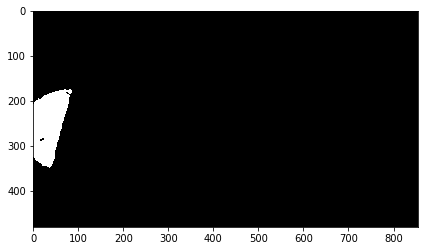

In [15]:
%%time
connected_img, connected_blobs = get_connected_components(image_no_noise)
io.imshow(connected_img)

In [16]:
connected_blobs.keys()

dict_keys([1])

In [17]:
connected_blobs[1][:10]

[[173, 82],
 [174, 70],
 [174, 71],
 [174, 72],
 [174, 81],
 [174, 82],
 [174, 83],
 [175, 69],
 [175, 70],
 [175, 71]]

### Draw bounding boxes

Given the original image and the blobs of the connected components, compute and draw bounding boxes on image

In [18]:
import matplotlib.patches as patches

def draw_bounding_boxes(img, components):
    # draw image
    fig,ax = plt.subplots(1)
    fig.set_size_inches((15,10))
    ax.imshow(img)
        
    for component in components:
        points = components[component]
        
        ys = [p[0] for p in points]
        xs = [p[1] for p in points]
        
        min_y = min(ys)
        min_x = min(xs)
        
        max_y = max(ys)
        max_x = max(xs)
        
        box_height = max_y - min_y
        box_width = max_x - min_x

        # create bounding box patch and add it to image
        rect = patches.Rectangle((min_x, min_y), box_width, box_height,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

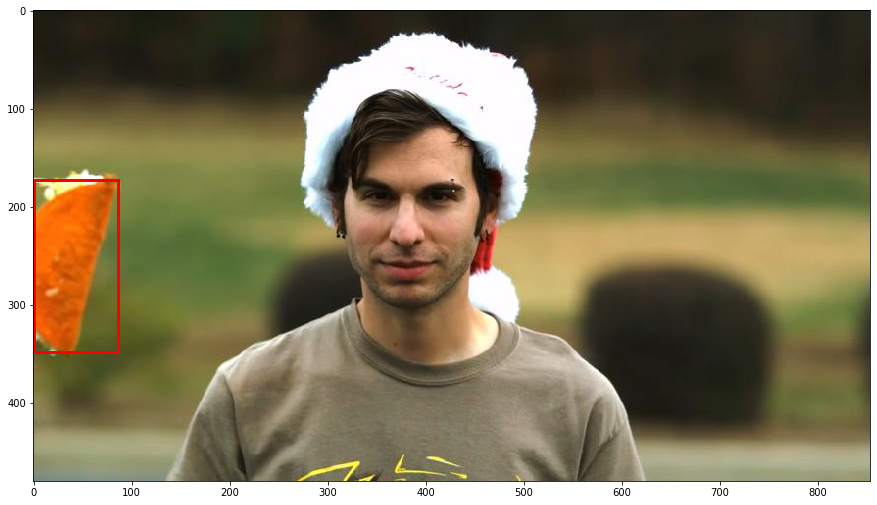

In [19]:
draw_bounding_boxes(image, connected_blobs)

## Exercise 1.3

* use your color detection and connected components algorithm
* implement simplest tracking algorithm
* draw history of all previous points on frame (**RESULT**)

(see images/racecar or images/taco for sample image sequences)

## Get some objects

Tracking objects only makes sense if we have at least 2 objects in the picture. We already have the taco, let's extract the hat too

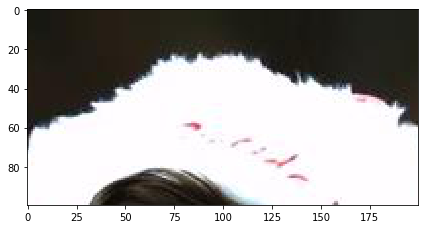

In [20]:
hat = image[0:100,300:500]
io.imshow(hat)

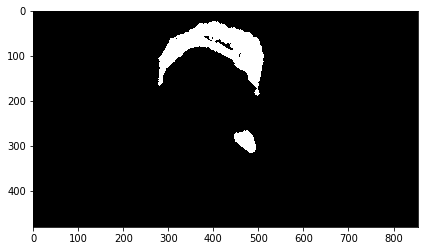

In [21]:
binary_hat = binarize(image, cube=[240, 240, 240], size=20)
io.imshow(dilate(erode(binary_hat)))

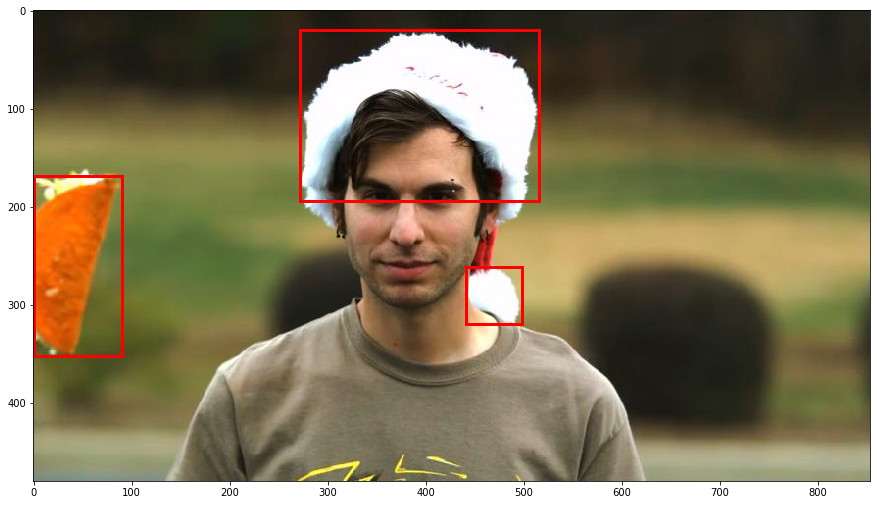

In [22]:
def get_tacos_and_hats(image):
    # note: we dilate twice so we connect very close connected components
    taco = dilate(dilate(erode(binarize(image, cube=[175, 70, 0], size=80))))
    hat = dilate(dilate(erode(binarize(image, cube=[240, 240, 240], size=20))))
    tacos_n_hats = taco + hat
    
    connected_img, connected_blobs = get_connected_components(tacos_n_hats)
    draw_bounding_boxes(image, connected_blobs)
    
get_tacos_and_hats(image)

## Approach to object tracking

For each image in the sequence: 

1. compute connected components for hats & tacos as in the cell above
1. if we have a prev image, find the nearest connected component from previous image to every one found in current image
1. use the same color to mark the average position of a connected component as was used for this component in the previous step

### A note on object positions

There are various way to define the "location" or center point of each object. Taking the middle of the boinding
box is probably the worst idea, as can be seen from the taco, as an object can have a very small part going too far in one direction. We are going to use the median of the x and y components individually.

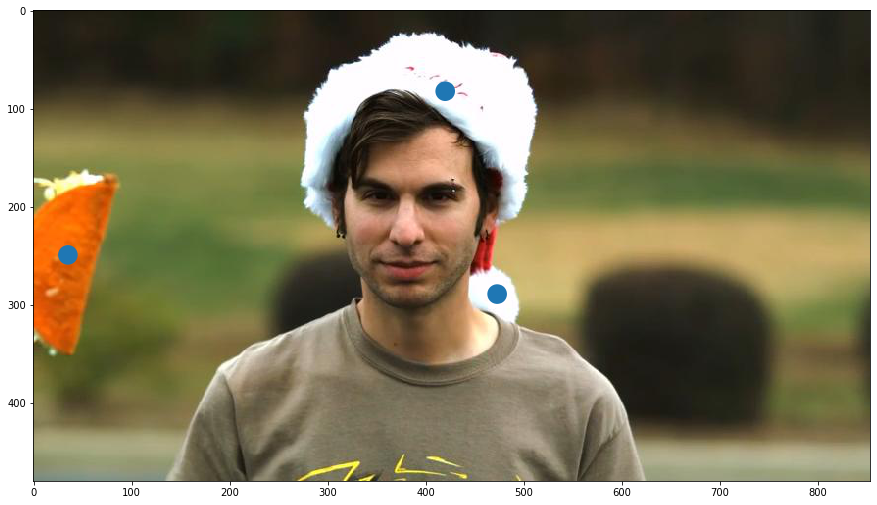

{1: array([ 82., 420.]), 105: array([249.,  35.]), 151: array([289., 473.])}

In [23]:
from matplotlib.patches import Circle

def draw_object_centers(image, prev_connected_components):
    ###################
    # draw image
    ###################
    fig,ax = plt.subplots(1)
    fig.set_size_inches((15,10))
    ax.imshow(image)
    
    ###################
    # get binary taco+hat image
    ###################
    
    # note: we dilate twice so we connect very close connected components
    taco = dilate(dilate(erode(binarize(image, cube=[175, 70, 0], size=80))))
    hat = dilate(dilate(erode(binarize(image, cube=[240, 240, 240], size=20))))
    tacos_n_hats = taco + hat
    
    ###################
    # get connected components
    # and draw median points on image 
    ###################
    connected_img, connected_blobs = get_connected_components(tacos_n_hats)
    object_positions = {}
    for component in connected_blobs:
        object_positions[component] = np.median(connected_blobs[component], axis=0)
        
        circ = Circle((object_positions[component][1], object_positions[component][0]),10)
        ax.add_patch(circ)
        
    plt.show()
    
    return object_positions
    
    
draw_object_centers(image, None)

### But what do we do when we have more/less objects in current image than in previous?

Well, we can't know which objects are noise and which not. For each object in the history, find the closest one in the current image (if it's visible) and treat others as new objects with their own history.

In [24]:
from tqdm import tqdm_notebook as tqdm

def get_objects_history(images):
    objects_history = []
    
    for image in tqdm(images):
        ###################
        # get binary taco+hat image
        ###################

        # note: we dilate twice so we connect very close connected components
        taco = dilate(dilate(erode(binarize(image, cube=[175, 70, 0], size=80))))
        hat = dilate(dilate(erode(binarize(image, cube=[240, 240, 240], size=20))))
        tacos_n_hats = taco + hat
    
        ###################
        # get objects' locations from current image
        ###################
        connected_img, connected_blobs = get_connected_components(tacos_n_hats)
        object_positions = []
        for component in connected_blobs:
            object_positions.append(np.median(connected_blobs[component], axis=0))
           
        # fist picture just initializes history
        if not objects_history:
            objects_history = [[x] for x in object_positions]
            continue
            
        # for each history object, get its latest position and find nearest
        # object from object_positions w.r.t. euclidean norm 
        for ho in objects_history:
            nearest_object_i = np.argmin([np.linalg.norm(ho[-1] - o) for o in object_positions])
            ho.append(object_positions[nearest_object_i])
            
            # we no longer consider the object, as it's now matched in history
            object_positions.pop(nearest_object_i)
        
    
    return objects_history

In [25]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def draw_object_history(history, image_shape):
    cmap = get_cmap(len(history) + 1)
    
    # draw blank image
    fig,ax = plt.subplots(1)
    fig.set_size_inches((15,10))
    ax.imshow(np.zeros(image_shape))
    
    for i, obj in enumerate(history):
        for j, (y,x) in enumerate(obj):
            # we are creating a fancy fade effect here, assigning opacity from .3 to 1. to each
            # point depending on how far it was in the history linearly
            circ = Circle((x, y), 10, color=cmap(i), alpha=.7 * (j + 1) / len(obj) + .3)
            ax.add_patch(circ)
            
    plt.show()

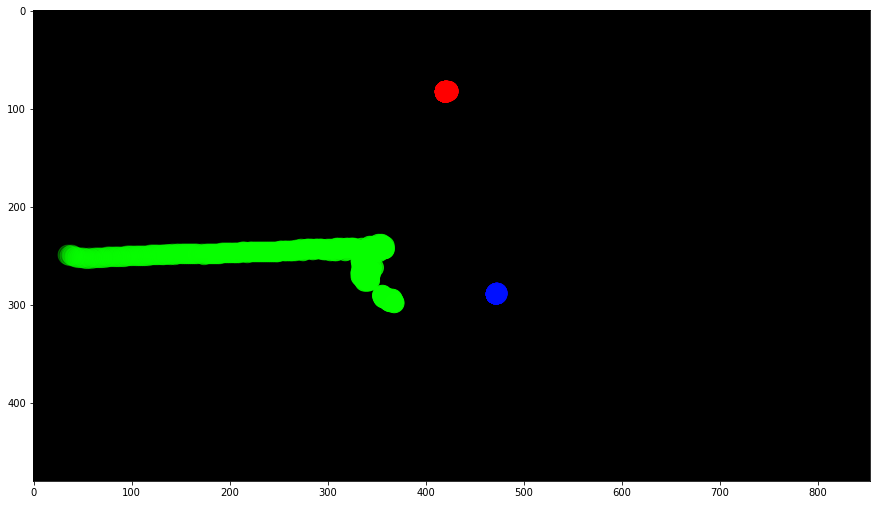

In [26]:
from os import listdir
images = [io.imread(f'./images/taco/{x}') for x in sorted(listdir('./images/taco'))]

draw_object_history(get_objects_history(images), images[0].shape)

# A note on performance

We implemented convolution operations the way they were explained in the lecture. In practice, one uses matrix multiplications, which significantly increases the performance. Naively, one could e.g. treat the kernel as a row vector and all the image snippets as columns in a matrix, then perform all matrix multiplications at once on a GPU and reshape the result accordingly. To keep the code understandable, we didn't implement such performance optimizations.